##### Import packages

In [165]:
import networkx as nx
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from scipy.integrate import solve_ivp
from numba import njit
import pickle, itertools


#### Introduction of the Gierer-Meinhardt model

In [166]:
u, v, a_, b_, eps, sig, x = sp.symbols('u v a_ b_ eps sig x')
f, g = a_ - b_*u + (u**2)/v, u**2-v
u_bar, v_bar = sp.solve((f,g),(u,v))[0]
f_u, f_v = sp.Derivative(f,u).subs({u:u_bar, v:v_bar}).doit(), sp.Derivative(f,v).subs({u:u_bar, v:v_bar}).doit()
g_u, g_v = sp.Derivative(g,u).subs({u:u_bar, v:v_bar}).doit(), sp.Derivative(g,v).subs({u:u_bar, v:v_bar}).doit()


#### Homogeneous solution of the Gierer-Meinhardt model

In [167]:
A_, B_ = (-1 + 2*eps*x*sig + (eps**2)*(x**2)*(sig**2))/(-1+eps*x*sig)**2, (eps**2)*(x**2)*sig
lam = (1/2)*(f_u+g_v+(1+sig)*eps*x + (4*f_v*g_u + (f_u-g_v+(1-sig)*eps*x)**2)**.5)
J = np.array([[-b_+2*u_bar/v_bar, -u_bar**2/v_bar**2], [2*u_bar, -1]])
eq = sp.solve((J[0,0]-x)*(J[1,1]-x)-J[1,0]*J[0,1], x)


#### Selection of the structural parameters

In [169]:
N, Ne, nb_runs = 30, 70, 500

# Import structural data
G, epsilon, sigma, AA, BB, U0, V0 = pickle.load(open('data/G_data.txt','rb'))

# Note: At this point, it is also possible to generate another networkx graph using per e.g. nx.gnm_random_graph(N,E,seed) to generate an Erdos-Renyi graph of N nodes and E edges, or nx.barabasi_albert_graph(N,m,seed) to generate a Albert-Barabasi graph of N nodes and attachment parameter m.
# The next cell entitled 'Selection of the dynamical parameters' will compute the rest of the parameters required to run the Gierer-Meinhardt model in order to form Turing patterns, namely the diffusion parameter (epsilon,sigma), the reaction parameters (AA,BB), and the homogeneous solution (U0,V0) to be used as the starting point of every Turing simulation, across the whole spectrum of G (i.e. for every pair of adjacent eigenmodes)

# Compute the Laplacian matrix before and after edge removal, and store the graph edge list
L, Ls, edgelist = -nx.laplacian_matrix(G).toarray().astype(float), [], list(G.edges)
for e in range(Ne):
    e1, e2 = edgelist[e]
    G.remove_edge(e1,e2)
    Ls.append(-nx.laplacian_matrix(G).toarray().astype(float))
    G.add_edge(e1,e2)

# Compute the Laplacian eigenvalue
eigenvalues, eigenvalues_after = np.linalg.eigh(L)[0], [np.linalg.eigh(Ls[e])[0] for e in range(Ne)]
print(eigenvalues)

[-1.21080082e+01 -9.80611970e+00 -9.11508248e+00 -8.45519443e+00
 -7.91012191e+00 -7.60768135e+00 -7.33613144e+00 -6.70329213e+00
 -6.63463916e+00 -6.20827196e+00 -5.87443418e+00 -5.10802681e+00
 -5.06606104e+00 -4.72559418e+00 -4.51530481e+00 -4.01667969e+00
 -3.60242376e+00 -3.40028570e+00 -3.05053279e+00 -2.85671019e+00
 -2.73348463e+00 -2.59885933e+00 -2.26284436e+00 -1.90427922e+00
 -1.86920269e+00 -1.38920527e+00 -1.20047455e+00 -1.13473590e+00
 -8.06318188e-01 -8.02520832e-16]


#### Selection of the dynamical parameters

In [6]:
# Select an exploration range for epsilon, the activator diffusion parameter
EPSILON = np.arange(0.01, .2501, 0.001)

# Place epsilon between the Hopf bifurcation limit and the limit of the positive kinetic parameter a>0
div = 0.8 # real number between 0 and 1

# Compute epsilon for each Laplacian eigenvalue of index i=1...N
def compute_eps_eig(eig_, upp_, eps_range, sig_, div_):
    global A_, B_, eq
    valid = 0
    a, b = A_.subs({sig:sig_, x:upp_[eig_]}), B_.subs({sig:sig_, x:upp_[eig_]})
    for eps_k in eps_range:
        eps_k = round(eps_k,3)
        akin = A_.subs({eps:eps_k, sig:sig_, x:upp_[eig_]})
        if akin > 0:
            ekin = eps_k
            valid += 1
            break
    lAB_bif = eq[0].subs({a_:a,b_:b})
    for eps_ in eps_range[::-1]:
        eps_ = round(eps_,3)
        lbif = lAB_bif.subs({eps:eps_,sig:sig_}).as_real_imag()[0]
        if str(lbif) != 'nan':
            if lbif < 0:
                ebif = eps_
                valid += 1
                break
    if valid == 2:
        emiddle = ekin + div_*(ebif-ekin)
        return emiddle
    else:
        return 0

print('Computing the diffusion parameter epsilon...')
epsilon = np.array([compute_eps_eig(eig, eigenvalues, EPSILON, 10, div) for eig in range(N)], order='C')

# Select sigma baseline value (on the edge of Turing instability)
sigma_baseline = 10

# Compute kinetic parameters a and b for each eigenvalue to obtain pairs of adjacent degenerate eigenmodes
def compute_AB(upp_, eps_, sig_base):
    global A_, B_
    # "x:(upp_[eig_]+upp_[eig_+1])/2" ensures the top of the parabola is placed between the degenerate eigenmodes eig and eig+1
    aa_, bb_ = [A_.subs({sig:sig_base, x:(upp_[eig_]+upp_[eig_+1])/2, eps:eps_[eig_]}) for eig_ in range(len(upp_)-1)], [B_.subs({sig:sig_base, x:(upp_[eig_]+upp_[eig_+1])/2, eps:eps_[eig_]}) for eig_ in range(len(upp_)-1)]
    return np.array(aa_).astype(float), np.array(bb_).astype(float)
    #return np.array(aa_+[-1]).astype(float), np.array(bb_+[-1]).astype(float)

print('Computing the kinetic parameters...')
AA, BB = compute_AB(eigenvalues, epsilon, sigma_baseline)

# Compute the growth rates of all the eigenmodes of G for the dynamical parameters sig, eps, a and b.
def growth_rates(upp, sig, eps, a, b):
    global f_u, f_v, g_u, g_v, u_bar, v_bar
    n, fu, fv, gu, gv = len(upp), f_u.subs({a_:a, b_:b}), f_v.subs({a_:a, b_:b}), g_u.subs({a_:a, b_:b}), g_v
    low = np.zeros(n,)
    for i in range(n):
        # Jacobian matrix
        A = np.matrix([[fu + eps*upp[i], fv], [gu, gv+sig*eps*upp[i]]], dtype=float)
        # Solving the Jacobian matrix of the model (extracting eigenvalues == eigenmode growth rates)
        low_lambda_i = np.linalg.eig(A)[0]
        # Select the upper branch, the only possibly positive solution (unstable eigenmode)
        low_lambda_i = low_lambda_i[ np.argmax(low_lambda_i.real) ]
        if low_lambda_i.imag != 0:
            low[i] = np.nan
        else:
            low[i] = low_lambda_i
    return low

# Compute the dsigma increase required to have the smallest unstable and largest stable growth rates approximately equal
def ds_parabol_coeff(eigenvalues_, aa_, bb_, epsilon_, eig_):
    global lam
    if eigenvalues_[eig_]-eigenvalues_[eig_-1]<= eigenvalues_[eig_+2]-eigenvalues_[eig_+1]:
        stable_eigenmode_index, unstable_eigenmode_index = eig_-1, eig_
    else:
        stable_eigenmode_index, unstable_eigenmode_index = eig_+2, eig_+1
    stable_growth_rate = lam.subs({a_:aa_[stable_eigenmode_index], b_:bb_[stable_eigenmode_index], x:eigenvalues_[stable_eigenmode_index], 
eps:epsilon_[stable_eigenmode_index]})
    unstable_growth_rate = lam.subs({a_:aa_[unstable_eigenmode_index], b_:bb_[unstable_eigenmode_index], x:eigenvalues_
[unstable_eigenmode_index], eps:epsilon_[unstable_eigenmode_index]})
    to_solve, bump = stable_growth_rate+unstable_growth_rate, 0
    siglist = sp.solve(to_solve, sig)
    while len(siglist) == 0 and bump<4:
        to_solve += 1e-6
        siglist = sp.solve(to_solve, sig)
        bump += 1
    if bump == 4:
        return 0
    else:
        # Keep the solution with negligeable imaginary part
        return sp.re(siglist[np.where(np.array([sp.im(i) for i in siglist])<1e-6)[0][0]])

# Compute sigma the inhibitor diffusion parameter for each eigenvalue susceptible of forming Turing patterns (only for positive diffusion epsilon).
print('Computing the diffusion parameter sigma...')
sigma = np.zeros(N, float, order='C')

for eig in np.where(AA>0)[0][1:]:
    sigma[eig] = ds_parabol_coeff(eigenvalues, AA, BB, epsilon, eig)
    if sigma[eig] == 0:
        break

# Select range of eigenvalues susceptible of forming Turing patterns (configurations with unstable eigenmodes)
eig_range = np.where(sigma>sigma_baseline)[0]

# Compute homogeneous solution (u,v) for every eigenmode
print('Computing the homogeneous solutions across the entire spectrum...')
U0, V0 = np.array([u_bar.subs({a_:AA[eig], b_:BB[eig]}) for eig in range(len(AA))]).astype(float), np.array([v_bar.subs({a_:AA[eig], b_:BB[eig]}) for eig in range(len(AA))]).astype(float)

print('Done.')

Computing the diffusion parameter epsilon...
Computing the kinetic parameters...
Computing the diffusion parameter sigma...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
Computing the homogeneous solutions across the entire spectrum...
Done.


#### Visualisation of the dispersion relation

(-0.03845690379729138, 0.00655122081037451)

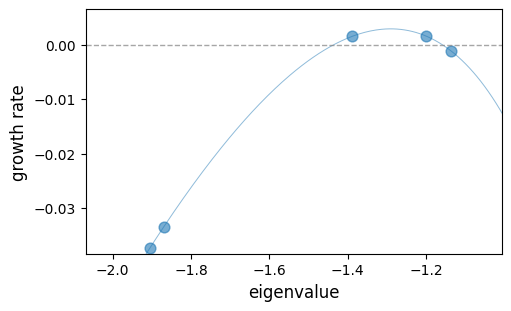

In [7]:
# Select the index eig to obtain 'eig' and 'eig+1' as degenerate eigenmodes (minimum value = 3, maximum value = 26)
eig = 25

# Compute the growth rates of all eigenvalues
growth_before = growth_rates(eigenvalues, sigma[eig], epsilon[eig], AA[eig], BB[eig])

# Display the dispersion relation (growth rates as a function of the Laplacian eigenvalues) near the Turing instability regime
X = np.linspace(eigenvalues[eig-3], eigenvalues[eig+3], 300)
Y = [sp.re(lam.subs({a_:AA[eig], b_:BB[eig], eps:epsilon[eig], sig:sigma[eig], x:i}).doit()) for i in X]
plt.figure(figsize=(5,3),constrained_layout=True)
plt.scatter(eigenvalues, growth_before, marker='o', c='tab:blue', alpha=.6, s=60)
plt.xlabel('eigenvalue', size=12)
plt.ylabel('growth rate', size=12)
plt.plot(X, Y, linestyle='-', lw=.7, alpha=.5, c='tab:blue')
plt.axhline(y=0, linestyle='--', lw=1, alpha=.7, c='grey')
plt.xlim(eigenvalues[eig-1]-.2, eigenvalues[eig+3]-.2)
plt.ylim(min(growth_before[eig-1], growth_before[eig+2])-.005, growth_before[eig]+.005)


#### Selection of the simulation parameters

In [8]:
# Select number of simulation runs, and number of steps per simulation
nb_runs, nb_steps, nb_steps_supp = 500, 3000, 1000
tspan, tspan_supp = np.linspace(0, nb_steps, nb_steps+1), np.linspace(0, nb_steps_supp, nb_steps_supp+1)

# Select radius of perturbation of the homogenous state, U(t=0) = U0 + 10^{-perturb}
perturb = 3


#### Simulation of Turing patterns

In [9]:
def simulation_run(lap, time, u_, v_, pert, sig_, eps_, a_, b_, method):
    # Simulate the Turing system of equations for 'time' steps
    n, tt = len(lap), (time[0], time[-1])
    # Initialise the system by introducing a random uniform perturbation of radius 10^{pert} to the homogeneous state (u_,v_)
    y0 = np.hstack((u_+np.random.uniform(-10**pert,10**pert,n), v_+np.random.uniform(-10**pert,10**pert,n)))
    # Solve the Turing system of equations
    sol = solve_ivp(turing, tt, y0, t_eval=(time), args=(lap,sig_,eps_,a_,b_,), method=method)
    return np.vsplit(sol.y,2)

def continue_run(lap, time, ut, vt, sig_, eps_, a_, b_, method):
    # Solve the Turing system of equations for 'time' steps
    tt = (time[0], time[-1])
    # Solve the Turing system of equations starting from the distribution of activators ut and inhibitors vt
    sol = solve_ivp(turing, tt, np.hstack((ut, vt)), t_eval=(time), args=(lap,sig_,eps_,a_,b_,), method=method)
    return np.vsplit(sol.y,2)

@njit
def turing(t, y, lap, sig_, eps_, a_, b_):
    u_vect, v_vect = np.array_split(y,2)
    # Concentration of activators as a function of time
    du_vect = a_ - b_*u_vect + u_vect**2/v_vect + eps_*lap.dot(np.ascontiguousarray(u_vect))
    # Concentration of inhibitors as a function of time
    dv_vect = u_vect**2 - v_vect + sig_*eps_*lap.dot(np.ascontiguousarray(v_vect))
    return np.hstack((du_vect,dv_vect))

# Turing patterns simulation
Us = np.zeros(N, np.ndarray)
# Consider only {eig,eig+1} pairs for which sigma>sigma_baseline=10, i.e. those for which (eig,eig+1) are unstable and susceptible of forming Turing patterns
for eig in eig_range:
    print('Eigenvector n°'+str(eig+1)+'...')
    Us[eig] = np.zeros(nb_runs, np.ndarray)
    for run in range(nb_runs):
        if run % 100 == 99 and run>0:
            print('Simulating run n°'+str(run+1)+'/'+str(nb_runs)+'...')
        U, V = simulation_run(L, tspan, U0[eig], V0[eig], -perturb, sigma[eig], epsilon[eig], AA[eig], BB[eig], 'Radau')
        # While a steady state hasn't been reached, continue running the model for another nb_steps_supp (1000) steps
        while np.allclose(U[:,-1],U[:,-100], atol=1e-5) == False:
            U, V = continue_run(L, tspan_supp, U[:,-1], V[:,-1], sigma[eig], epsilon[eig], AA[eig], BB[eig], 'Radau')
        # Store the steady state, i.e., the concentration of activator of the last step of this simulation run
        Us[eig][run] = U[:,-1]

# Save the set of simulation results in a pickle file
with open('newdata/original_patterns.txt','wb') as f:
	pickle.dump(Us, f)


0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450


#### Pattern diversity analysis

In [11]:
# Select the Pearson correlation threshold to consider two Turing patterns to be similar
similarity_thres = 0.9
# Select the minimal amplitude (maximun minus minimum activator concentration) required to differentiate Turing patterns from homogeneous states
min_amplitude = 0.1

# Select the index eig for which 'eig' and 'eig+1' are degenerate eigenmodes (minimum value = 3, maximum value = 26)
eig = 25

# Filter Turing patterns out of all the stored steady states
patterns = [i for i in Us[eig] if max(i)-min(i) > min_amplitude]

# Identify distinct Turing patterns and compute their multiplicity
def compute_multiplicity(um, thres):
    # pattern_types is the set of distinct Turing patterns
    # pattern_repository collects and groups together similar Turing patterns
    # multi stores the multiplicity of each distinct Turing patterns (directly measured from pattern_repository)
    pattern_types, pattern_repository, multi = [um[0]], [[um[0]]], [1]
    for u in um[1:]:
        # Correlate each pattern u with all the previously identified distinct patterns pattern_types
        corr_p = np.array([pearsonr(u, p)[0] for p in pattern_types])
        # If u is not highly correlated (has a Pearson correlation coefficient below thres) with any of the previously identified distinct Turing patterns, identify it as a new distinct Turing pattern
        if all(corr_p < thres):
            pattern_types.append(u)
            pattern_repository.append([u])
            multi.append(1)
        else:
            # If u correlates with at least one of the previously identified distinct Turing patterns, assign it to the one Turing pattern it correlates with the most
            p_update = np.argmax(corr_p)
            pattern_repository[p_update].append(u)
            # Update the identified distinct Turing pattern as the node-by-node average of all the Turing patterns belonging to that group
            pattern_types[p_update] = np.array([np.mean([p[i] for p in pattern_repository[p_update]]) for i in range(N)])
            multi[p_update] += 1
    # Output the set of distinct Turing patterns and their respective multiplicity
    return pattern_types, multi

def compute_diversity(mul):
    # Compute the pattern diversity using mul, the multiplicity of that Turing pattern
    return 1 - sum([i*(i-1)/2 for i in mul])/(sum(mul)*(sum(mul)-1)/2)

patterns_distinct, multiplicity, diversity_array = np.zeros(N, np.ndarray), np.zeros(N, np.ndarray), np.zeros(N, np.ndarray)
if len(patterns):
    patterns_distinct, multiplicity = compute_multiplicity(patterns, similarity_thres)
    # Compute the resulting pattern diversity
    diversity = compute_diversity(multiplicity)
    print(str(len(multiplicity))+' distinct Turing patterns of multiplicity '+str(multiplicity)+'.\nConvergence frequency = '+str(sum(multiplicity))+'/'+str(nb_runs)+' = '+str(round(sum(multiplicity*100)/nb_runs))+'%\nPattern diversity = '+str(round(diversity,2)))
else:
    print('Missing input, please first run a set of simulations')

multiplicity_ratio = np.array([i/sum(multiplicity) for i in multiplicity])

4 distinct Turing patterns of multiplicity [96, 133, 114, 157].
Convergence frequency = 500/500 = 100%
Pattern diversity = 0.74


#### Visualisation of Turing patterns

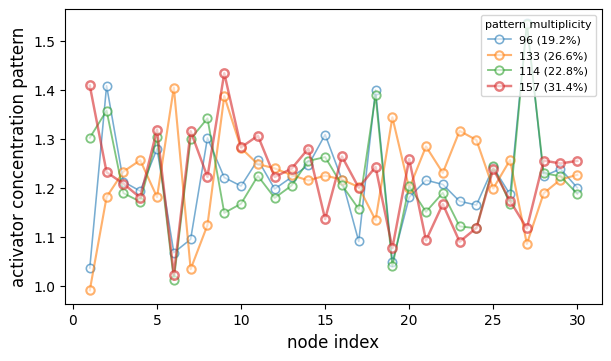

In [ ]:
plt.figure(figsize=(6,3.5), constrained_layout=True)
nb_patterns = len(patterns_distinct)
for i in range(nb_patterns):
    # Define the thickness of every pattern to model its multiplicity
    thickness = .2+5*multiplicity_ratio[i]
    plt.plot(range(1,N+1), patterns_distinct[i], markersize=6, marker='o', markerfacecolor='w', markeredgewidth=thickness, alpha=.6, lw=thickness, label=str(multiplicity[i])+' ('+str(round(100*multiplicity_ratio[i],1))+'%)')

plt.xlabel('node index', size=12)
plt.ylabel('activator concentration pattern', size=12)
plt.legend(title='pattern multiplicity', fontsize=8, title_fontsize=8)


#### Visualisation of the dispersion relation after edge removal

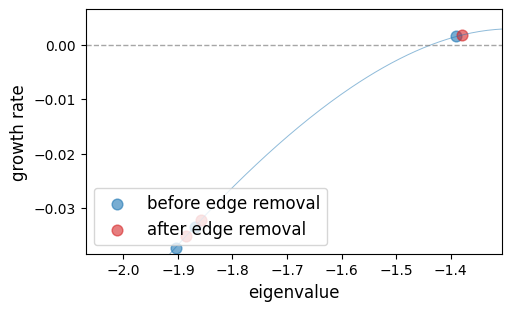

In [13]:
# Compute the growth rates before edge removal
growth_before = growth_rates(eigenvalues, sigma[eig], epsilon[eig], AA[eig], BB[eig])

# Select edge to remove
e = 12

# Compute Laplacian eigenvalue after edge removal
eigenvalues_after = np.linalg.eigh(Ls[e])[0]

# Compute the growth rates after edge removal
growth_after = growth_rates(eigenvalues_after, sigma[eig], epsilon[eig], AA[eig], BB[eig])

# Display the dispersion relation (growth rates as a function of the Laplacian eigenvalues) near the Turing instability regime, before and after edge removal
X = np.linspace(eigenvalues[eig-3], eigenvalues[eig+3], 300)
Y = [sp.re(lam.subs({a_:AA[eig], b_:BB[eig], eps:epsilon[eig], sig:sigma[eig], x:i}).doit()) for i in X]
plt.figure(figsize=(5,3), constrained_layout=True)
plt.scatter(eigenvalues, growth_before, marker='o', c='tab:blue', s=60, alpha=.6, label='before edge removal')
plt.scatter(eigenvalues_after, growth_after, marker='o', c='tab:red', s=60, alpha=.6, label='after edge removal')
plt.xlabel('eigenvalue', size=12)
plt.ylabel('growth rate', size=12)
plt.plot(X, Y, linestyle='-', lw=.7, alpha=.5, c='tab:blue')
plt.axhline(y=0, linestyle='--', lw=1, alpha=.7, c='grey')
plt.xlim(eigenvalues[eig-1]-.2, eigenvalues[eig+3]-.2)
plt.ylim(min(growth_before[eig-1], growth_before[eig+2])-.005, growth_before[eig]+.005)
plt.legend(loc='lower left', fontsize=12)


#### Simulation of Turing patterns after edge removal

In [14]:
# Remove the edge e from the graph (single structural perturbation)
e1, e2 = edgelist[e]
G.remove_edge(e1,e2)

Us_after = np.zeros(nb_runs, np.ndarray)
if eig in eig_range:
    for run in range(nb_runs):
        if run % 100 == 99 and run>0:
            print('Simulating run n°'+str(run+1)+'/'+str(nb_runs)+'...')
        U, V = simulation_run(L, tspan, U0[eig], V0[eig], -perturb, sigma[eig], epsilon[eig], AA[eig], BB[eig], 'Radau')
        # While a steady state hasn't been reached, continue running the model for another nb_steps_supp steps
        while np.allclose(U[:,-1],U[:,-100], atol=1e-5) == False:
            U, V = continue_run(L, tspan_supp, U[:,-1], V[:,-1], sigma[eig], epsilon[eig], AA[eig], BB[eig], 'Radau')
        # Store the steady state, i.e., the concentration of activator of the last step of this simulation run
        Us_after[run] = U[:,-1]
else:
    print('Index n°'+str(eig)+' cannot create Turing patterns, please select another eig')

# Adding back the edge e to the graph
G.add_edge(e1,e2)


Simulating run n°100/500...
Simulating run n°200/500...
Simulating run n°300/500...
Simulating run n°400/500...
Simulating run n°500/500...


#### Pattern diversity after edge removal

In [18]:
# Filter Turing patterns out of all the stored steady states
patterns_after = [i for i in Us_after if max(i)-min(i) > min_amplitude]

# Identify distinct Turing patterns and compute their multiplicity
if len(patterns_after):
    patterns_distinct_after, multiplicity_after = compute_multiplicity(patterns_after, similarity_thres)
    # Compute resulting pattern diversity
    diversity_after = compute_diversity(multiplicity)
    print(str(len(multiplicity_after))+' distinct Turing patterns of multiplicity '+str(multiplicity_after)+'.\nConvergence frequency = '+str(sum(multiplicity_after))+'/'+str(nb_runs)+' = '+str(round(sum(multiplicity_after*100)/nb_runs))+'%\nPattern diversity = '+str(round(diversity_after,2)))
else:
    print('Missing input, please first run a set of simulations')

multiplicity_ratio_after = np.array([i/sum(multiplicity_after) for i in multiplicity_after])

4 distinct Turing patterns of multiplicity [127, 95, 152, 126].
Convergence frequency = 500/500 = 100%
Pattern diversity = 0.74


#### Visualisation of Turing patterns after edge removal

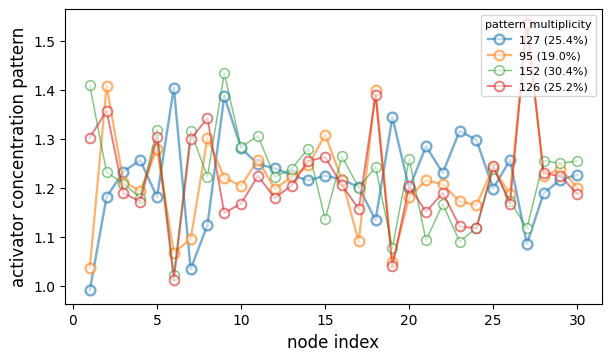

In [19]:
plt.figure(figsize=(6,3.5), constrained_layout=True)
nb_patterns_after = len(patterns_distinct_after)
for i in range(nb_patterns_after):
    thickness = .2+5*multiplicity_ratio[i]
    plt.plot(range(1,N+1), patterns_distinct_after[i], markersize=7, marker='o', markerfacecolor='w', markeredgewidth=thickness, alpha=.6, lw=thickness, label=str(multiplicity_after[i])+' ('+str(round(100*multiplicity_ratio_after[i],2))+'%)')

plt.xlabel('node index', size=12)
plt.ylabel('activator concentration pattern', size=12)
plt.legend(title='pattern multiplicity', fontsize=8, title_fontsize=8)


### Multistability analysis across the entire spectrum of a graph

#### Import simulation data to study the influence of edge removal

In [15]:
N, Ne = 30, 70
nb_runs = 500

# Import structural data
G, epsilon, sigma, AA, BB, U0, V0 = pickle.load(open('data/G_data.txt','rb'))
# Compute the Laplacian matrices before and after edge removal, and store the graph edge list
L, Ls, edgelist = -nx.laplacian_matrix(G).toarray().astype(float), [], list(G.edges)
for e in range(Ne):
    e1, e2 = edgelist[e]
    G.remove_edge(e1,e2)
    Ls.append(-nx.laplacian_matrix(G).toarray().astype(float))
    G.add_edge(e1,e2)

# Compute the Laplacian eigenvalues before and after edge removal
eigenvalues, eigenvalues_after = np.linalg.eigh(L)[0], [np.linalg.eigh(Ls[e])[0] for e in range(Ne)]

# Import simulation results across the whole spectrum
# before edge removal
print('Importing simulation results before edge removal...')
U1 = pickle.load(open('data/original_patterns.txt','rb'))

# after edge removal
U2 = np.zeros((N,Ne), np.ndarray)
for e in range(Ne):
    print('Importing simulation results after removing edge n°'+str(e+1)+'...')
    U2[:,e] = pickle.load(open('data/perturbed_patterns_edge_'+str(e)+'.txt','rb'))


Importing simulation results before edge removal...
Importing simulation results after removing edge n°1...
Importing simulation results after removing edge n°2...
Importing simulation results after removing edge n°3...
Importing simulation results after removing edge n°4...
Importing simulation results after removing edge n°5...
Importing simulation results after removing edge n°6...
Importing simulation results after removing edge n°7...
Importing simulation results after removing edge n°8...
Importing simulation results after removing edge n°9...
Importing simulation results after removing edge n°10...
Importing simulation results after removing edge n°11...
Importing simulation results after removing edge n°12...
Importing simulation results after removing edge n°13...
Importing simulation results after removing edge n°14...
Importing simulation results after removing edge n°15...
Importing simulation results after removing edge n°16...
Importing simulation results after removing e

#### Processing simulation data

In [17]:
# Select the Pearson correlation threshold to consider two Turing patterns to be similar
similarity_thres = 0.9
# Select the minimal amplitude (maximun minus minimum activator concentration) required to differentiate Turing patterns from homogeneous states
min_amplitude = 0.1
# Select Turing convergence threshold, i.e., the minimum proportion of Turing patterns for an eigenmode-edge pair to be considered 'convergent' enough
convergence_thres = 0.9

# Filter Turing patterns out of all the stored steady states
filter_before = np.array([sum(max(U1[eig][run])-min(U1[eig][run])> min_amplitude for run in range(nb_runs))/nb_runs for eig in range(N-3)])
filter_after = np.array([[sum(max(U2[eig,e][run])-min(U2[eig,e][run])> min_amplitude for run in range(nb_runs))/nb_runs for e in range(Ne)] for eig in range(N-3)])

# Identify distinct Turing patterns and compute their multiplicity before and after edge removal, and the resulting pattern diversity variation
patterns_distinct_before, multiplicity_before = np.zeros(N-3, list), np.zeros(N-3, list)
patterns_distinct_after, multiplicity_after = np.zeros((N-3,Ne), list), np.zeros((N-3,Ne), list)
pattern_diversity_before, pattern_diversity_after, pattern_diversity_variation = np.zeros(N-3, float), np.zeros((N-3,Ne), float), np.zeros((N-3,Ne), float)
for eig in range(N-3):
    print('Computing pattern diversity for eigenmode n°'+str(eig+1)+'...')
    # If the system converges often enough to Turing patterns before edge removal
    if filter_before[eig] > convergence_thres:
        # compute pattern diversity before edge removal
        patterns_distinct_before[eig], multiplicity_before[eig] = compute_multiplicity(U1[eig], similarity_thres)
        pattern_diversity_before[eig] = compute_diversity(multiplicity_before[eig])
        for e in range(Ne):
            # If the system converges oten enough to Turing patterns after the removal of edge e
            if filter_after[eig,e] > convergence_thres:
                # compute pattern diversity after edge removal
                patterns_distinct_after[eig,e], multiplicity_after[eig,e] = compute_multiplicity(U2[eig,e], similarity_thres)
                pattern_diversity_after[eig,e] = compute_diversity(multiplicity_after[eig,e])
                # compute pattern diversity variation
                pattern_diversity_variation[eig,e] = pattern_diversity_after[eig,e] - pattern_diversity_before[eig]

print('Done.')

Computing pattern diversity for eigenmode n°1...
Computing pattern diversity for eigenmode n°2...
Computing pattern diversity for eigenmode n°3...
Computing pattern diversity for eigenmode n°4...
Computing pattern diversity for eigenmode n°5...
Computing pattern diversity for eigenmode n°6...
Computing pattern diversity for eigenmode n°7...
Computing pattern diversity for eigenmode n°8...
Computing pattern diversity for eigenmode n°9...
Computing pattern diversity for eigenmode n°10...
Computing pattern diversity for eigenmode n°11...
Computing pattern diversity for eigenmode n°12...
Computing pattern diversity for eigenmode n°13...
Computing pattern diversity for eigenmode n°14...
Computing pattern diversity for eigenmode n°15...
Computing pattern diversity for eigenmode n°16...
Computing pattern diversity for eigenmode n°17...
Computing pattern diversity for eigenmode n°18...
Computing pattern diversity for eigenmode n°19...
Computing pattern diversity for eigenmode n°20...
Computing

#### Visualisation of pattern diversity changes after edge removal

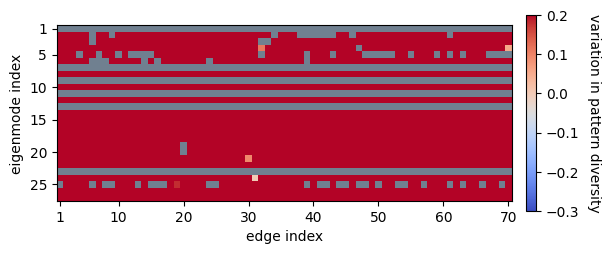

In [18]:
# Select Turing convergence threshold (eigenmode-edge cells to mask)
convergence_thres = 0.9

# Constrain color coding to a lower and upper bound value of pattern diversity variation
minimum_variation, maximum_variation = -0.3, 0.2

# Separate the cells to display (if Turing convergence is above the defined threshold) or mask (otherwise)
detect = np.array([filter_before>convergence_thres for e in range(Ne)]).T*(filter_after>convergence_thres)
to_display, to_mask = np.ma.masked_array(pattern_diversity_variation, ~detect), np.ma.masked_array(pattern_diversity_variation, detect)

# Display the matrix of variations in pattern diversity
fig = plt.figure(figsize=(6,4), constrained_layout=True)
p = plt.imshow(to_display, cmap='coolwarm')
cbar = fig.colorbar(p, shrink=.5, pad=0.02, orientation='vertical')
cbar.ax.set_ylabel('variation in pattern diversity', rotation=270, labelpad=16)
plt.clim(minimum_variation, maximum_variation)
plt.imshow(to_mask, ListedColormap(['slategray']))
plt.xlabel('edge index')
plt.ylabel('eigenmode index')
xticks, yticks = np.array([0]+list(np.arange(9,Ne,10))), np.array([0]+list(np.arange(4,N-3,5)))
_ = plt.xticks(xticks, labels=xticks+1)
_ = plt.yticks(yticks, labels=yticks+1)


#### Computation of the structural sensitivity of eigenvalues after edge removal

In [19]:
# Compute the structural sensitivity of the eigenmodes S, M and U for each edge removal
S_sensitivity, M_sensitivity, U_sensitivity = np.zeros((N-3,Ne), float), np.zeros((N-3,Ne), float), np.zeros((N-3,Ne), float)

# Compute the Laplacian eigenvalues before and after edge removal
eigenvalues, eigenvalues_after = np.linalg.eigh(L)[0], [np.linalg.eigh(Ls[e])[0] for e in range(Ne)]
# Compute the Laplacian local spectral gaps
local_spectral_gaps = eigenvalues[1:]-eigenvalues[:-1]

for e in range(Ne):
    # Compute the structural sensitivity of the eigenmode S after removal of the edge e
    S_sensitivity[1:,e] = (eigenvalues_after[e][:-4]-eigenvalues[:-4])/local_spectral_gaps[:-3]
    # Compute the structural sensitivity of the eigenmode U after removal of the edge e
    U_sensitivity[1:,e] = (eigenvalues_after[e][2:-2]-eigenvalues[2:-2])/local_spectral_gaps[2:-1]
    # Compute the distance between the structural sensitivity of the eigenmode M after removal of the edge e and 0.5 (this quantity serves as a proxy for the distance between the growth rate of eigenmode M and the top of the locally-parabolic dispersion relation)
    M_sensitivity[1:,e] = abs((eigenvalues_after[e][1:-3]-eigenvalues[1:-3])/local_spectral_gaps[1:-2] - 0.5)


In [20]:
# Average pattern diversity variation on G
avg_variation = np.mean(pattern_diversity_variation[np.where(detect)])
print('Observed average pattern diversity variation =', avg_variation)

# Identify below average pattern diversity variation
negative_observations = np.multiply(pattern_diversity_variation<avg_variation, detect)

# Identify above average pattern diversity variation
positive_observations = np.multiply(pattern_diversity_variation>=avg_variation, detect)

# Define negative criterion predicting above average pattern diversity variation
def negative_criterion(S_sensi, s_max, M_sensi, mu_max, U_sensi, u_min):
    return (S_sensitivity<=s_max)*(M_sensitivity<=mu_max)*(U_sensitivity>=u_min)

# note: setting mu_max=0.5 means to not restrict according to the structural sensitivity of eigenmode M
negative_predictions = negative_criterion(S_sensitivity, 0.8, M_sensitivity, 0.5, U_sensitivity, 0.3)
negative_predictions = np.multiply(negative_predictions, detect)

# Define positive criterion predicting below average pattern diversity variation
def positive_criterion(S_sensi, s_min, M_sensi, mu_min, U_sensi, u_max):
    return (S_sensitivity>=s_min)*(M_sensitivity>=mu_min)*(U_sensitivity<=u_max)

# note: setting s_min=0 means to not restrict according to the structural sensitivity of eigenmode S
positive_predictions = positive_criterion(S_sensitivity, 0.0, M_sensitivity, 0.4, U_sensitivity, 0.1)
positive_predictions = np.multiply(positive_predictions, detect)


Observed average pattern diversity variation = 0.631464479746331


#### Visualisation of the prediction performance

Negative Predictive Value = 0.8803418803418803
Positive Predictive Value = 0.8333333333333334
Accuracy = 0.85473411154345


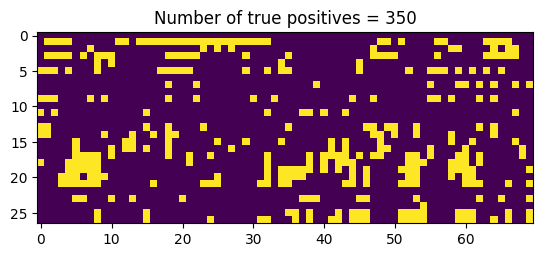

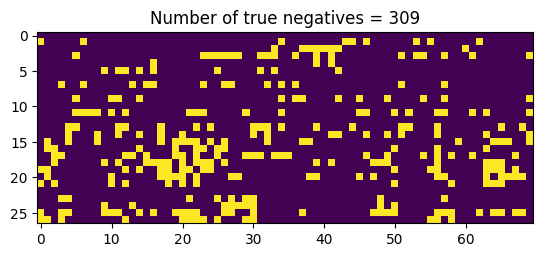

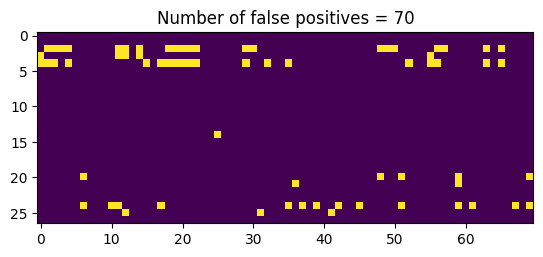

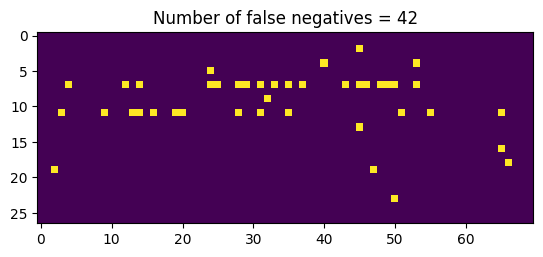

<Figure size 640x480 with 0 Axes>

In [21]:
# True positives are above average pattern diversity variations (observations) verifying the defined positive criterion
true_positives = np.multiply(positive_predictions, positive_observations)

# True negatives are below average pattern diversity variations (observations) verifying the defined negative criterion
true_negatives = np.multiply(negative_predictions, negative_observations)

# False positives are below average pattern diversity variations (observations) verifying the defined positive criterion
false_positives = np.multiply(positive_predictions, negative_observations)

# False negatives are above average pattern diversity variations (observations) verifying the defined negative criterion
false_negatives = np.multiply(negative_predictions, positive_observations)

TP, TN, FP, FN = np.sum(true_positives), np.sum(true_negatives), np.sum(false_positives), np.sum(false_negatives)

fig, ax = plt.subplots(2, 2, figsize=(7,10), constrained_layout=True)
ax[0,0].imshow(true_positives)
ax[0,0].set_title('Number of true positives = '+str(TP))
ax[0,1].imshow(true_negatives)
ax[0,1].set_title('Number of true negatives = '+str(TN))
ax[1,0].imshow(false_positives)
ax[1,0].set_title('Number of false positives = '+str(FP))
ax[1,1].imshow(false_negatives)
ax[1,1].set_title('Number of false negatives = '+str(FN))
plt.show()

# Evaluate the performance of the negative criterion, i.e., our ability to correctly predict low (below average) pattern diversity changes
NPV = TN/(TN+FN)
print('Negative Predictive Value = '+str(NPV))

# Evaluate the performance of the positive criterion, i.e., our ability to correctly predict high (above average) pattern diversity changes
PPV = TP/(TP+FP)
print('Positive Predictive Value = '+str(PPV))

# Evaluate the performance of both the negative and positive criteria
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy = sdfsd'+str(ACC))


### Identification of left and right spectral gaps

In [22]:
# Compute the growth rates before edge removal
growth_before = np.array([growth_rates(eigenvalues, sigma[eig], epsilon[eig], AA[eig], BB[eig]) for eig in range(N-3)])

# Separate spectral gaps into two subsets depending on whihc is the narrowest side of the dispersion relation (S-side = 0, U-side = 1)
def identify_gaps(eigenvalues_):
    # assign 1 if the spectral gap on the U-side of the dispersion relation is narrower, assign 0 otherwise
    # note that the first (S-side) spectral gap is always the largest and hence, always takes 0
    return np.array([0]+[int(eigenvalues_[eig_]-eigenvalues_[eig_-1]<= eigenvalues_[eig_+2]-eigenvalues_[eig_+1]) for eig_ in range(1, len(eigenvalues_)-3)])

gaps = identify_gaps(eigenvalues)
# Create filter identifying cases belonging to \alpha_S
S_filter = np.array([gaps for e in range(Ne)]).T
# Create filter identifying cases belonging to \alpha_U
U_filter = np.invert(S_filter)+2


#### Computation of the PPV and NPV matrices

In [37]:
# Define the ranges of all the possible values (boundaries) of the sensitivity of eigenmodes S, M, U
S_range, M_range, U_range = np.arange(0, 1.01, .05), np.arange(0, 0.51, .025), np.arange(0, 1.01, .05)
range_length = range(len(S_range))

# Create PPV and NPV matrices, for \alpha\in\alpha_S, \alpha\in\alpha_U and both (all instances)
PPV, NPV = np.zeros((len(U_range),len(M_range),len(S_range)), float), np.zeros((len(U_range),len(M_range),len(S_range)), float)
PPV_S, NPV_S = np.zeros((len(U_range),len(M_range),len(S_range)), float), np.zeros((len(U_range),len(M_range),len(S_range)), float)
PPV_U, NPV_U = np.zeros((len(U_range),len(M_range),len(S_range)), float), np.zeros((len(U_range),len(M_range),len(S_range)), float)

# Create pos_cases and neg_cases, measuring the percentage of instances predicted to produce above-average (positive) and below-average (negative) pattern diversity variations
pos_cases, neg_cases = np.zeros((len(U_range),len(M_range),len(S_range)), float), np.zeros((len(U_range),len(M_range),len(S_range)), float)
pos_cases_S, neg_cases_S = np.zeros((len(U_range),len(M_range),len(S_range)), float), np.zeros((len(U_range),len(M_range),len(S_range)), float)
pos_cases_U, neg_cases_U = np.zeros((len(U_range),len(M_range),len(S_range)), float), np.zeros((len(U_range),len(M_range),len(S_range)), float)

# Iterate over all possible combinations of boundaries on S, M and U
for i,j,k in itertools.product(range_length, repeat=3):
    u,m,s = U_range[i], M_range[j], S_range[k]
    # Create filters to predict low (negative condition) and high (positive condition) pattern diversity changes
    negative_predictions = np.multiply(negative_criterion(S_sensitivity, s, M_sensitivity, m, U_sensitivity, u), detect)
    positive_predictions = np.multiply(positive_criterion(S_sensitivity, s, M_sensitivity, m, U_sensitivity, u), detect)

    # Compute the total number of (eig,e) pairs that form Turing patterns (to be used to normalize the total number of positive and negative predictions)
    nb_cases, nb_cases_S, nb_cases_U = np.sum(detect), np.sum(np.multiply(detect, S_filter)), np.sum(np.multiply(detect, U_filter))
    
    pos_cases[i,j,k], pos_cases_S[i,j,k], pos_cases_U[i,j,k] = 100*np.sum(positive_predictions)/nb_cases, 100*np.sum(np.multiply(positive_predictions, S_filter))/nb_cases_S, 100*np.sum(np.multiply(positive_predictions, U_filter))/nb_cases_U
    neg_cases[i,j,k], neg_cases_S[i,j,k], neg_cases_U[i,j,k] = 100*np.sum(negative_predictions)/nb_cases, 100*np.sum(np.multiply(negative_predictions, S_filter))/nb_cases_S, 100*np.sum(np.multiply
(negative_predictions, U_filter))/nb_cases_U
    
    # Identify correct positive predictions overall, for left and right spectral gaps configurations
    true_positives = np.multiply(positive_predictions, positive_observations)
    true_positives_S, true_positives_U = np.multiply(true_positives, S_filter), np.multiply(true_positives, U_filter)

    # Identify correct negative predictions overall, for left, and right spectral gaps configurations
    true_negatives = np.multiply(negative_predictions, negative_observations)
    true_negatives_S, true_negatives_U = np.multiply(true_negatives, S_filter), np.multiply(true_negatives, U_filter)

    # Identify uncorrect positive predictions overall, for left and right spectral gaps configurations
    false_positives = np.multiply(positive_predictions, negative_observations)
    false_positives_S, false_positives_U = np.multiply(false_positives, S_filter), np.multiply(false_positives, U_filter)

    # Identify uncorrect negative predictions overall, for left, and right spectral gaps configurations
    false_negatives = np.multiply(negative_predictions, positive_observations)
    false_negatives_S, false_negatives_U = np.multiply(false_negatives, S_filter), np.multiply(false_negatives, U_filter)

    # Compute the number of true positive, true negative, false positive and false negative instances assuming u, m, and s as boundaries to the structural sensitivity of the eigenmodes U, M and S
    TP, TN, FP, FN = np.sum(true_positives), np.sum(true_negatives), np.sum(false_positives), np.sum(false_negatives)
    TP_S, TN_S, FP_S, FN_S = np.sum(true_positives_S), np.sum(true_negatives_S), np.sum(false_positives_S), np.sum(false_negatives_S)
    TP_U, TN_U, FP_U, FN_U = np.sum(true_positives_U), np.sum(true_negatives_U), np.sum(false_positives_U), np.sum(false_negatives_U)
    
    # Compute the Negative Predictive Value and the Positive Predictive assuming u, m, and s as boundaries to the structural sensitivity of the eigenmodes U, M and S
    NPV[i,j,k], PPV[i,j,k] = TN/(TN+FN), TP/(TP+FP)
    NPV_S[i,j,k], PPV_S[i,j,k] = TN_S/(TN_S+FN_S), TP_S/(TP_S+FP_S)
    NPV_U[i,j,k], PPV_U[i,j,k] = TN_U/(TN_U+FN_U), TP_U/(TP_U+FP_U)


C:\Users\selim\AppData\Local\Temp\ipykernel_4116\717311301.py:48: RuntimeWarning: invalid value encountered in scalar divide
  NPV[i,j,k], PPV[i,j,k] = TN/(TN+FN), TP/(TP+FP)
C:\Users\selim\AppData\Local\Temp\ipykernel_4116\717311301.py:49: RuntimeWarning: invalid value encountered in scalar divide
  NPV_S[i,j,k], PPV_S[i,j,k] = TN_S/(TN_S+FN_S), TP_S/(TP_S+FP_S)
C:\Users\selim\AppData\Local\Temp\ipykernel_4116\717311301.py:50: RuntimeWarning: invalid value encountered in scalar divide
  NPV_U[i,j,k], PPV_U[i,j,k] = TN_U/(TN_U+FN_U), TP_U/(TP_U+FP_U)


#### Visualisation of the PPV and NPV matrices (merging $\alpha_U$ and $\alpha_S$)

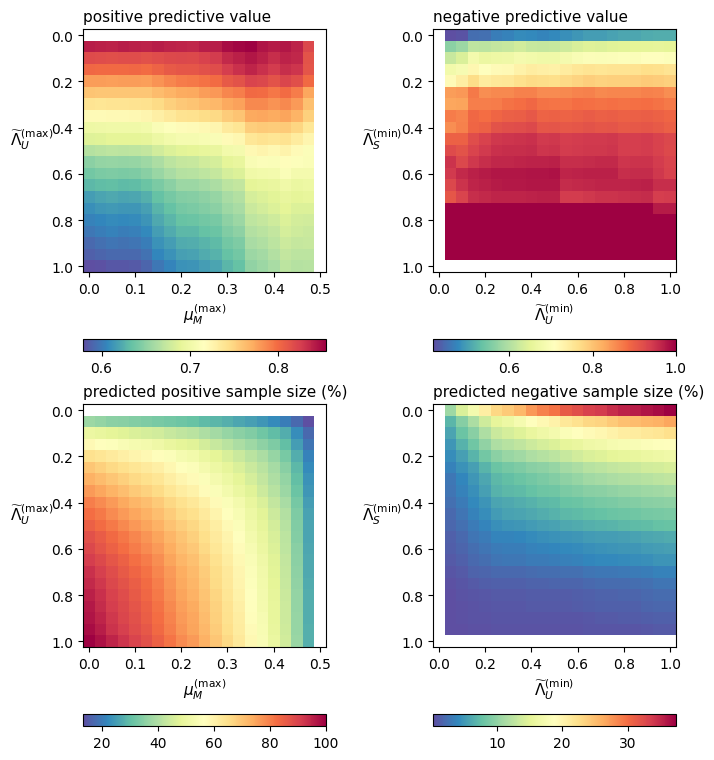

In [157]:
# Out of the three possible structural sensitivities of {U,M,S}, fix one parameter and display the two others as a gradient (matrix form), in the case of positive and negative predictions
positive_fixed_param = 'S' # default='S', e.g. in the manuscript, c+ does not include a boundary on S
negative_fixed_param = 'M' # default='M', e.g. in the manuscript, c- does not include a boundary on M

# Select the boundary of the fixed parameter
positive_fixed_value = 0
negative_fixed_value = 0.4

# Identify the two remaining structural sensitivities to be used as matrix axes
positive_varying_param = list({'U','M','S'}^{positive_fixed_param})
negative_varying_param = list({'U','M','S'}^{negative_fixed_param})

def value_to_index(sign, param, val):
    '''
    Convert the input boundary value (val) of the structural sensitivity of S, M or U (param) in the case of positive or negative criterion (sign)
    '''
    param_axis = {'U':0, 'M':1, 'S':2}[param] # identify the axis of the single fixed parameter
    idx = int(10*val)
    if param == 'M':
        # The structural sensitivity of M (mu, in the manuscript) varies between 0 and 0.5, whereas that of {U,S} can vary between 0 and 1, hence, the extra multiplier 2 when converting a value from M into an index
        idx *= 2
    if sign=='pos' and param == 'U' or sign=='neg' and param in ['M','S']:
        # Start pointer from the end when identifying a maximum boundary, see Section 3.1 of the manuscript
        return -idx, param_axis
    else:
        # and from the beginning when identifying a minimum boundary
        return idx, param_axis

# Identify the selected value and index of the fixed parameter to be omitted for visualisation
pos_idx, pos_axis = value_to_index('pos', positive_fixed_param, positive_fixed_value)
neg_idx, neg_axis = value_to_index('neg', negative_fixed_param, negative_fixed_value)

def param_to_labels(both_params):
    '''
    Generates adequate labels depending on the positive or negative criterion chosen parameters (params), i.e. which of the structural sensitivities of U, M or S are to be used for prediction
    '''
    nb_params = len(both_params)
    labels = np.zeros(nb_params, object) # stores axes labels, displaying which parameters constitute the positive criterion (on even indices) or the negative criterion (on odd indices)
    ticklabels = np.zeros(nb_params, np.ndarray) # stores axes ticklabels, displaying which parameters constitute the positive criterion (even indices) or the negative criterion (on odd indices)
    for i in range(len(both_params)):
        p = both_params[i]
        if i%2 == 0:
            labels[i] = bool(p=='U')*'$\\widetilde{\\Lambda}_{U}^{(\\min)}$' + bool(p=='M')*'$\\mu_{M}^{(\\max)}$' + bool(p=='S')*'$\\widetilde{\\Lambda}_{S}^{(\\max)}$'
        else:
            labels[i] = bool(p=='U')*'$\\widetilde{\\Lambda}_{U}^{(\\max)}$' + bool(p=='M')*'$\\mu_{M}^{(\\min)}$' + bool(p=='S')*'$\\widetilde{\\Lambda}_{S}^{(\\min)}$'
        if p == 'M':
            ticklabels[i] = np.round(np.arange(0,0.6,.1),1)
        else:
            ticklabels[i] = np.round(np.arange(0,1.1,.2),1)
    return labels[::2], labels[1::2], ticklabels[::2], ticklabels[1::2]

# Create the axes labels for visualisation
xlabels, ylabels, xticklabels, yticklabels = param_to_labels(positive_varying_param + negative_varying_param)

# Select the font size of labels and titles for visualisation
fontsize = 11

# Display the PPV and NPV matrices, and their respective percentage of predicted sample size
fig, ax = plt.subplots(2, 2, figsize=(7,7.5), constrained_layout=True)
p = [ax[0,0].imshow(np.take(PPV, pos_idx, axis=pos_axis), cmap='Spectral_r'),
     ax[0,1].imshow(np.take(NPV, neg_idx, axis=neg_axis), cmap='Spectral_r'),
     ax[1,0].imshow(np.take(np.where(pos_cases==0, np.nan, pos_cases), pos_idx, axis=pos_axis), cmap='Spectral_r'),
     ax[1,1].imshow(np.take(np.where(neg_cases==0, np.nan, neg_cases), neg_idx, axis=neg_axis), cmap='Spectral_r')]
_ = [fig.colorbar(p[i], ax=ax[i//2,i%2], orientation='horizontal', fraction=.05) for i in range(4)]
_ = [ax[i//2, i%2].set_xlabel(xlabels[i%2], size=fontsize) for i in range(4)] 
_ = [ax[i//2, i%2].set_ylabel(ylabels[i%2], rotation=0, labelpad=14, size=fontsize) for i in range(4)] 
_ = [ax[i//2, i%2].set_xticks(np.arange(0,21,4), labels=xticklabels[i%2]) for i in range(4)]
_ = [ax[i//2, i%2].set_yticks(np.arange(0,21,4), labels=yticklabels[i%2]) for i in range(4)]
_ = ax[0,0].set_title('positive predictive value', size=fontsize, loc='left')
_ = ax[0,1].set_title('negative predictive value', size=fontsize, loc='left')
_ = ax[1,0].set_title('predicted positive sample size (%)', size=fontsize, loc='left')
_ = ax[1,1].set_title('predicted negative sample size (%)', size=fontsize, loc='left')


#### Visualisation of the PPV matrices (separating $\alpha_S$ and $\alpha_U$)

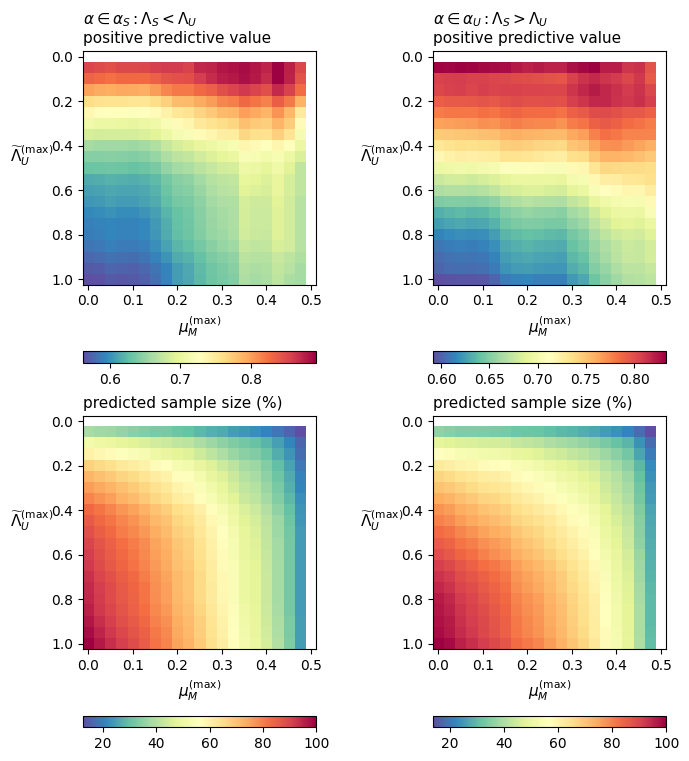

In [162]:
# Display the PPV matrices for \alpha\in\alpha_S and \alpha\in\alpha_U, and their respective percentage of predicted cases
fig, ax = plt.subplots(2, 2, figsize=(7, 7.5), constrained_layout=True)
p = [ax[0,0].imshow(np.take(PPV_S, pos_idx, axis=pos_axis), cmap='Spectral_r'),
     ax[0,1].imshow(np.take(PPV_U, pos_idx, axis=pos_axis), cmap='Spectral_r'),
     ax[1,0].imshow(np.take(np.where(pos_cases_S==0, np.nan, pos_cases_S), pos_idx, axis=pos_axis), cmap='Spectral_r'),
     ax[1,1].imshow(np.take(np.where(pos_cases_U==0, np.nan, pos_cases_U), pos_idx, axis=pos_axis), cmap='Spectral_r')]
_ = [fig.colorbar(p[i], ax=ax[i//2,i%2], orientation='horizontal', fraction=.05) for i in range(4)]
_ = [ax[i//2, i%2].set_xlabel(xlabels[0], size=fontsize) for i in range(4)] 
_ = [ax[i//2, i%2].set_ylabel(ylabels[0], rotation=0, labelpad=14, size=fontsize) for i in range(4)] 
_ = [ax[i//2,i%2].set_xticks(np.arange(0,21,4), labels=xticklabels[0]) for i in range(4)]
_ = [ax[i//2,i%2].set_yticks(np.arange(0,21,4), labels=yticklabels[0]) for i in range(4)]
_ = ax[0,0].set_title('$\\alpha\\in\\alpha_S: \\Lambda_S<\\Lambda_U$\npositive predictive value', size=fontsize, loc='left')
_ = ax[0,1].set_title('$\\alpha\\in\\alpha_U: \\Lambda_S>\\Lambda_U$\npositive predictive value', size=fontsize, loc='left')
_ = [ax[1,i].set_title('predicted sample size (%)', size=fontsize, loc='left') for i in range(2)]


#### Visualisation of the NPV matrices (separating $\alpha_S$ and $\alpha_U$)

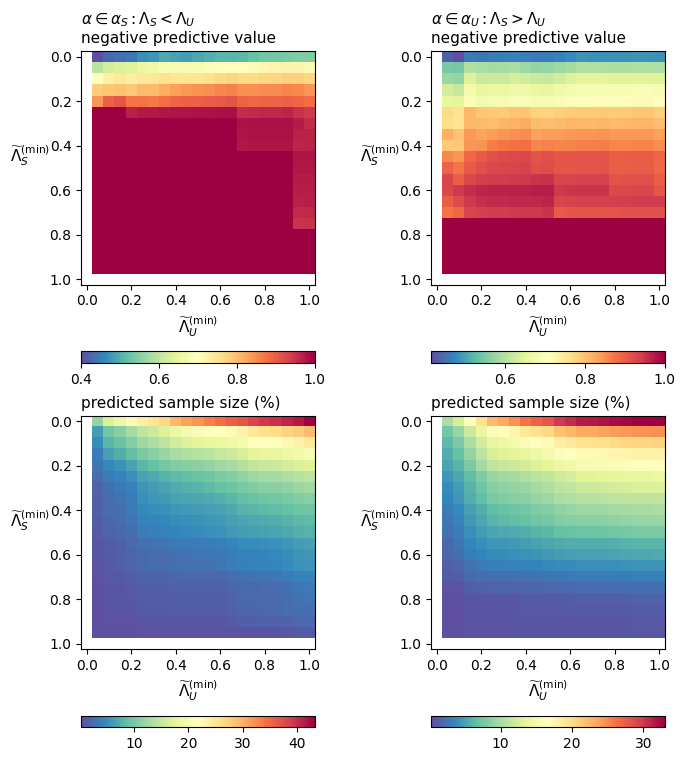

In [164]:
# Display the NPV matrices for \alpha\in\alpha_S and \alpha\in\alpha_U, and their respective percentage of predicted cases
fig, ax = plt.subplots(2, 2, figsize=(7, 7.5), constrained_layout=True)
p = [ax[0,0].imshow(np.take(NPV_S, neg_idx, axis=neg_axis), cmap='Spectral_r'),
     ax[0,1].imshow(np.take(NPV_U, neg_idx, axis=neg_axis), cmap='Spectral_r'),
     ax[1,0].imshow(np.take(np.where(neg_cases_S==0, np.nan, neg_cases_S), neg_idx, axis=neg_axis), cmap='Spectral_r'),
     ax[1,1].imshow(np.take(np.where(neg_cases_U==0, np.nan, neg_cases_U), neg_idx, axis=neg_axis), cmap='Spectral_r')]
_ = [fig.colorbar(p[i], ax=ax[i//2,i%2], orientation='horizontal', fraction=.05) for i in range(4)]
_ = [ax[i//2, i%2].set_xlabel(xlabels[1], size=fontsize) for i in range(4)] 
_ = [ax[i//2, i%2].set_ylabel(ylabels[1], rotation=0, labelpad=14, size=fontsize) for i in range(4)] 
_ = [ax[i//2,i%2].set_xticks(np.arange(0,21,4), labels=xticklabels[1]) for i in range(4)]
_ = [ax[i//2,i%2].set_yticks(np.arange(0,21,4), labels=yticklabels[1]) for i in range(4)]
_ = ax[0,0].set_title('$\\alpha\\in\\alpha_S: \\Lambda_S<\\Lambda_U$\nnegative predictive value', size=fontsize, loc='left')
_ = ax[0,1].set_title('$\\alpha\\in\\alpha_U: \\Lambda_S>\\Lambda_U$\nnegative predictive value', size=fontsize, loc='left')
_ = [ax[1,i].set_title('predicted sample size (%)', size=fontsize, loc='left') for i in range(2)]
